In [67]:
import sys
sys.path.append('/Users/isabelcorpus/.pyenv/versions/3.9.0/lib/python3.9/site-packages')
import pandas as pd
import numpy as np 
import matplotlib as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from analysis_helper import *
import torch
import json
import seaborn as sns
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torcheval.metrics import MulticlassAccuracy
from sentence_transformers import SentenceTransformer

In [68]:
# Prepare data: 
# load files, normalize embeddings, preprocess for analysis and modeling 
news = pd.read_csv("data/MINDsmall_train/news.tsv", sep='\t', 
                   names = ["news_id", "category", "subcategory", "title", "abstract", "url", "title_entities", "abstract_entities"])
news = process_tsv(news, ['title_entities', 'abstract_entities'])

entity_id, entity_vec = load_embeddings('data/MINDsmall_train/entity_embedding.vec')
relation_id, relation_vec = load_embeddings('data/MINDsmall_train/relation_embedding.vec')

entity_vec = normalize(entity_vec)

# extract WikiData Knowledge Graph entity IDs for title and abstract
news['title_entity_ids'] = extract_entity_list(news, 'title_entities', 'WikidataId')
news['abstract_entity_ids'] = extract_entity_list(news, 'abstract_entities', 'WikidataId')

# mean pool entity embeddings to create news embeddings  
news_embeddings = mean_pooled_news_embeddings(entity_vec, entity_id, news, "title_entity_ids")

/Users/isabelcorpus/sample_project/mind/analysis_helper/preprocessing.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col_i].fillna('{}', inplace=True)


In [ ]:
# Generate sentence-bert embeddings using pretrained SBERT model 
# load pre-trained sbert 
sbert = SentenceTransformer('all-MiniLM-L6-v2')
title_embeddings = sbert.encode(np.vstack(news.title))

# join embeddings with news metadata 
title_embedding_df = pd.DataFrame(zip(news.news_id, title_embeddings), columns = ["news_id", "title_embedding"])
news_title_entity = pd.merge(title_embedding_df, news_embeddings, how = "inner", on = "news_id")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/isabelcorpus/.pyenv/versions/3.9.0/envs/sample_proj_env/lib/python3.9/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.9 is maybe too old for this OS.
  warnings.warn(


<Axes: >

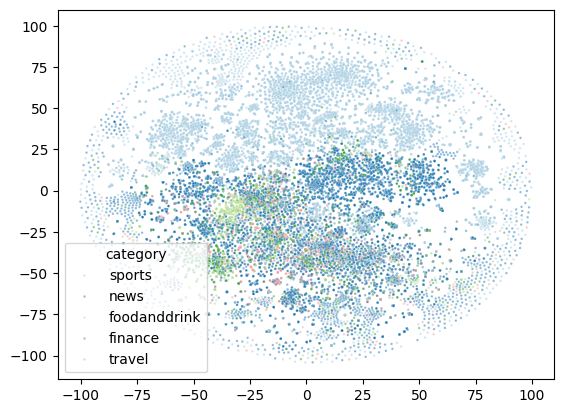

In [73]:
# visualize top 5 categories via tsne 
top_cat_vecs = news_embeddings[news_embeddings.category.isin(["sports", "news", "finance", "travel", "foodanddrink"])].reset_index()
top_cat_vecs = top_cat_vecs.groupby(['news_id', 'category']).entity_vec.apply(lambda x: np.mean(x, axis=0)).reset_index()

tsne_x, tsne_y = prepare_tsne_data(top_cat_vecs, 'entity_vec', 'category')

# fit + transform TSNE
tsne_X = TSNE(n_components=2, learning_rate=200, init='random', perplexity=15).fit_transform(tsne_x)

# tsne visualization - not very useful! may require additional fine tuning to improve clustering, or data 
# may be ill-suited for qualitative understanding of clusters with tsne  
sns.scatterplot(
    x = tsne_X[:,0], y = tsne_X[:,1],
    hue = tsne_y, 
    palette = sns.color_palette("Paired", 5),
    legend = "full",
    alpha = 0.5, 
    s = 3
)

In [74]:
# recode category field as integer, create Dataset and load into DataLoader for training 
news_embeddings['Numerical_Category'] = cat_to_int(news_embeddings, "category")

# create Dataset for which each X - pooled entity embeddings, y - category of news
news_dataset = NewsDataset(np.vstack(news_embeddings.entity_vec), news_embeddings['Numerical_Category'])

# split 0.8 training, 0.2 test 
train_dataset, test_dataset = test_training_split(news_dataset, 0.8)
loader = DataLoader(train_dataset, shuffle=True, batch_size = 10)
test_loader = DataLoader(test_dataset, shuffle=True)

In [75]:
# simple sequential NN to predict news category  
model = multiclass_classifier()
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001) 

trained_model, train_acc, train_loss = train_model(model, loss_fn, optimizer, 20, loader)
validate_model(trained_model, loss_fn, test_loader)

epoch: 0, training loss: 6825.96210205555, training accuracy: 0.3837530314922333
epoch: 1, training loss: 6676.656878829002, training accuracy: 0.6263466477394104
epoch: 2, training loss: 6647.309961915016, training accuracy: 0.6233167052268982
epoch: 3, training loss: 6645.07420027256, training accuracy: 0.6197818517684937
epoch: 4, training loss: 6644.22975063324, training accuracy: 0.6201858520507812
epoch: 5, training loss: 6641.868779182434, training accuracy: 0.6121060848236084
epoch: 6, training loss: 6645.4330422878265, training accuracy: 0.6205897927284241
epoch: 7, training loss: 6652.358041167259, training accuracy: 0.6197144985198975
epoch: 8, training loss: 6627.002266526222, training accuracy: 0.6088405847549438
epoch: 9, training loss: 6620.078483343124, training accuracy: 0.6084702610969543
epoch: 10, training loss: 6629.886222481728, training accuracy: 0.6153043508529663
epoch: 11, training loss: 6626.872374892235, training accuracy: 0.6106585264205933
epoch: 12, train

(tensor(0.6344), 16777.729769468307)

In [85]:
# Use SBERT embeddings as input to NN, compare results 
news_title_entity['Numerical_Category'] = cat_to_int(news_title_entity, "category")
news_title_entity_ds = NewsDataset(np.vstack(news_title_entity.title_embedding), news_title_entity['Numerical_Category'])
sbert_train_dataset, sbert_test_dataset = test_training_split(news_title_entity_ds, 0.8)
sbert_loader = DataLoader(sbert_train_dataset, shuffle=True, batch_size = 10)
sbert_test_loader = DataLoader(sbert_test_dataset, shuffle=True)

In [86]:
# sbert model; out performs mean pooled entity embeddings 
model = multiclass_classifier_title()
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001) 

trained_model_sbert, train_acc, train_loss = train_model(model, loss_fn, optimizer, 20, sbert_loader)
validate_model(trained_model_sbert, loss_fn, sbert_test_loader)

epoch: 0, training loss: 6383.343490242958, training accuracy: 0.6571842432022095
epoch: 1, training loss: 6286.343554258347, training accuracy: 0.6968421936035156
epoch: 2, training loss: 6264.484388709068, training accuracy: 0.6988957524299622
epoch: 3, training loss: 6255.427268624306, training accuracy: 0.6837126016616821
epoch: 4, training loss: 6246.652498722076, training accuracy: 0.6924319863319397
epoch: 5, training loss: 6238.887929916382, training accuracy: 0.6782925128936768
epoch: 6, training loss: 6243.720192432404, training accuracy: 0.6835779547691345
epoch: 7, training loss: 6236.056980371475, training accuracy: 0.6829046607017517
epoch: 8, training loss: 6237.096158146858, training accuracy: 0.6753972768783569
epoch: 9, training loss: 6234.142115473747, training accuracy: 0.6764745712280273
epoch: 10, training loss: 6228.212426900864, training accuracy: 0.675161600112915
epoch: 11, training loss: 6239.43101143837, training accuracy: 0.6868098378181458
epoch: 12, train

(tensor(0.6829), 15720.782215356827)

In [104]:
# Re-train simple NN with different set of inputs: concatenate pooled entity vectors with SBERT embedding  of title
concat_embeddings = np.concatenate((np.vstack(news_title_entity.title_embedding), np.vstack(news_title_entity.entity_vec)), axis = 1)


In [109]:
# predicting category with concatenated embeddings (entity; title sbert) provides best training, test accuracy, hooray!
news_title_entity_ds = NewsDataset(concat_embeddings, news_title_entity['Numerical_Category'])
concat_train_dataset, concat_test_dataset = test_training_split(news_title_entity_ds, 0.8)
concat_loader = DataLoader(concat_train_dataset, shuffle = True, batch_size = 10)
concat_test_loader = DataLoader(concat_test_dataset, shuffle = True)

model = multiclass_classifier_concat()
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001) 

trained_model_concat, train_acc, train_loss = train_model(model, loss_fn, optimizer, 20, concat_loader)
validate_model(trained_model_concat, loss_fn, concat_test_loader)

epoch: 0, training loss: 6410.004061818123, training accuracy: 0.6733099818229675
epoch: 1, training loss: 6195.830601334572, training accuracy: 0.7362307906150818
epoch: 2, training loss: 6151.97735273838, training accuracy: 0.7497979998588562
epoch: 3, training loss: 6123.590398550034, training accuracy: 0.7585510611534119
epoch: 4, training loss: 6100.781435251236, training accuracy: 0.7637692093849182
epoch: 5, training loss: 6081.750968575478, training accuracy: 0.7672030925750732
epoch: 6, training loss: 6066.967938423157, training accuracy: 0.7695260047912598
epoch: 7, training loss: 6053.284987807274, training accuracy: 0.7716805934906006
epoch: 8, training loss: 6039.591368317604, training accuracy: 0.7746095061302185
epoch: 9, training loss: 6029.131922364235, training accuracy: 0.778144359588623
epoch: 10, training loss: 6018.243043541908, training accuracy: 0.7795583009719849
epoch: 11, training loss: 6010.226933002472, training accuracy: 0.7813088893890381
epoch: 12, train

(tensor(0.7638), 15566.95414686203)